In [4]:
import os
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt

In [28]:
# load vic parameter file
vic_param = nc.Dataset('/lustre/nobackup/WUR/ESG/liu297/vic_indus/11indus_run/05Parameters/VIC_params_Modis_calibrated_Indus.nc')
# print out the variable names
print(f'vic_parameter file has following variables: \n {vic_param.variables.keys()}\n')
domain = nc.Dataset('/lustre/nobackup/WUR/ESG/liu297/vic_indus/11indus_run/05Parameters/domain_Indus.nc') #load mask file
mask = np.flip(domain.variables['mask'][:],axis = 0).mask # 

vic_parameter file has following variables: 
 dict_keys(['AreaFract', 'Nelev', 'Pfactor', 'elev', 'elevation', 'lat', 'lon', 'snow_band', 'Ds', 'Dsmax', 'Ws', 'c', 'infilt', 'annual_prec', 'avg_T', 'run_cell', 'Cv', 'LAI', 'Nveg', 'RGL', 'albedo', 'displacement', 'fcanopy', 'month', 'overstory', 'rad_atten', 'rarc', 'rmin', 'root_depth', 'root_fract', 'root_zone', 'trunk_ratio', 'veg_class', 'veg_rough', 'wind_atten', 'wind_h', 'b_co2', 'Ksat', 'Nlayer', 'Wcr_FRACT', 'Wfc_FRACT', 'Wpwp_FRACT', 'bubble', 'bulk_density', 'depth', 'dp', 'expt', 'fs_active', 'init_moist', 'phi_s', 'quartz', 'resid_moist', 'rough', 'snow_rough', 'soil_density'])



plot the Ksat to check what area might have capillary rise

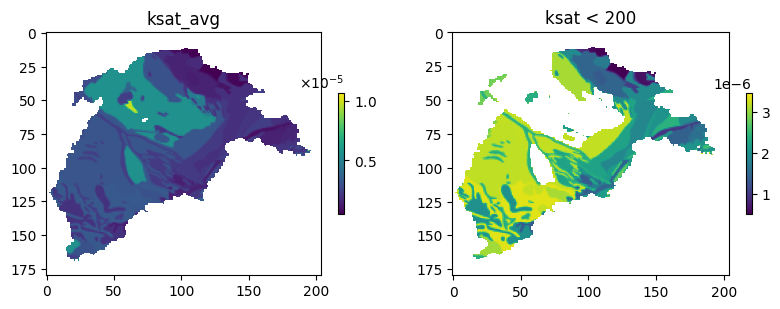

In [158]:
# load the ksat parameter
ksat = vic_param.variables['Ksat'][:]
# split the ksat into 3 layers and do unit conversion from mm/day to m/s

ksat_layer1 = ksat[0, :, :] / (1000 * 24 * 3600)
ksat_layer2 = ksat[1, :, :] / (1000 * 24 * 3600)
ksat_layer3 = ksat[2, :, :] / (1000 * 24 * 3600)
# do an average of the 3 layers
ksat_avg =( (ksat_layer1 + ksat_layer2 + ksat_layer3) / 3).data
ksat_avg[mask] = np.nan
ksat200 = ksat_avg.copy()
ksat200[ksat200 > 300/1000/24/3600] = np.nan

#subplots ksat_avg, ksat200
fig, ax = plt.subplots(1, 2, figsize=(8, 3))
ax[0].imshow(ksat_avg)
ax[0].set_title('ksat_avg')
fig.colorbar(ax[0].imshow(ksat_avg), ax=ax[0], orientation='vertical',  format=ticker.ScalarFormatter(useMathText=True),shrink=0.5  )

ax[1].imshow(ksat200)
ax[1].set_title('ksat < 200')
import matplotlib.ticker as ticker

fig.colorbar(ax[1].imshow(ksat200), ax=ax[1], orientation='vertical', fraction=.1, format=ticker.ScalarFormatter(useMathText=False),shrink=0.5   )

plt.tight_layout()
plt.show()




<class 'numpy.ndarray'>


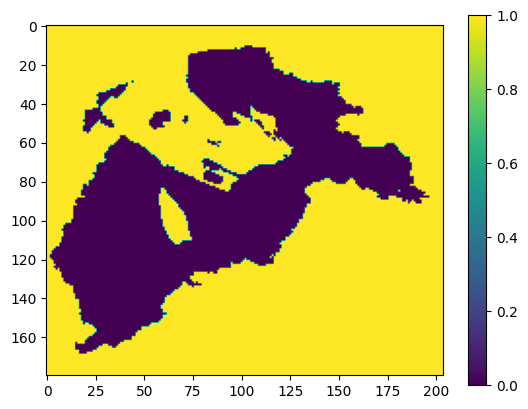

In [160]:
# create a maskarray from ksat200
ksat200_mask = np.ma.masked_array(ksat200, mask=np.isnan(ksat200)).mask
plt.imshow(ksat200_mask)
plt.colorbar()
print(type(ksat200_mask))

calculate the effective porosity n = bulk_density/soil_density


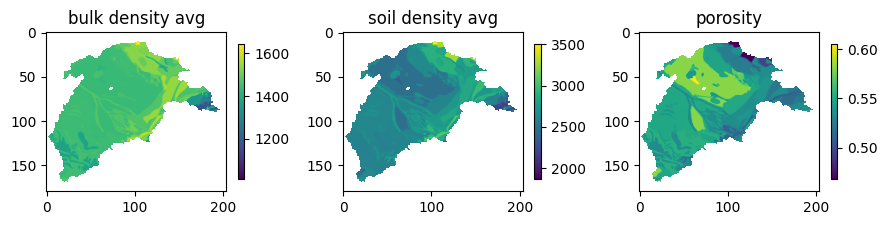

In [146]:
bulk_density = vic_param.variables['bulk_density']
bulk_density=np.flip(bulk_density,axis=0)
bulk_density1 = bulk_density[0, :, :]
bulk_density2 = bulk_density[1, :, :]
bulk_density3 = bulk_density[2, :, :]
bulk_density_avg = ((bulk_density1 + bulk_density2 + bulk_density3) / 3).data
bulk_density_avg[mask] = np.nan

soil_density = vic_param.variables['soil_density']
soil_density1 = soil_density[0, :, :]
soil_density2 = soil_density[1, :, :]
soil_density3 = soil_density[2, :, :]
soil_density_avg = ((soil_density1 + soil_density2 + soil_density3) / 3).data
soil_density_avg[mask] = np.nan

porosity = bulk_density_avg / soil_density_avg
porosity1 = bulk_density1 / soil_density1
porosity2 = bulk_density2 / soil_density2
porosity3 = bulk_density3 / soil_density3



fig, ax = plt.subplots(1, 3, figsize=(9, 3))
im0 = ax[0].imshow(bulk_density_avg)
ax[0].set_title('bulk density avg')
fig.colorbar(im0, ax=ax[0],shrink=0.5)

im1 = ax[1].imshow(soil_density_avg)
ax[1].set_title('soil density avg')
fig.colorbar(im1, ax=ax[1],shrink=0.5)

im2 = ax[2].imshow(porosity)
ax[2].set_title('porosity')
fig.colorbar(im2, ax=ax[2],shrink=0.5)

plt.tight_layout()
plt.show()

CPsurface has 15167 non-nan values
max depth is 2.536641397169828
min depth is 2.0184067477595584
max CPsurface is 6162.756475754599
min CPsurface is -2.0660883658684575


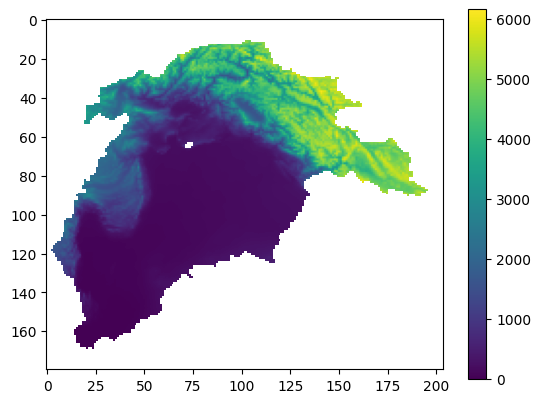

In [147]:
surface = vic_param.variables['elev'][:]
surface = np.flip(surface,axis=0)
surface[mask] = np.nan


depth = vic_param.variables['depth'][2, :, :]
depth = np.flip(depth,axis=0)
depth[mask] = np.nan
CPsurface = surface - depth
plt.imshow(CPsurface)
print(f'CPsurface has {np.count_nonzero(~np.isnan(CPsurface))} non-nan values')
print(f'max depth is {np.nanmax(depth)}')
print(f'min depth is {np.nanmin(depth)}')
print(f'max CPsurface is {np.nanmax(CPsurface)}')
print(f'min CPsurface is {np.nanmin(CPsurface)}')
plt.colorbar()




estimate hc


min hc is 1.5063829003760536 m
max hc is 5.410660576344763 m


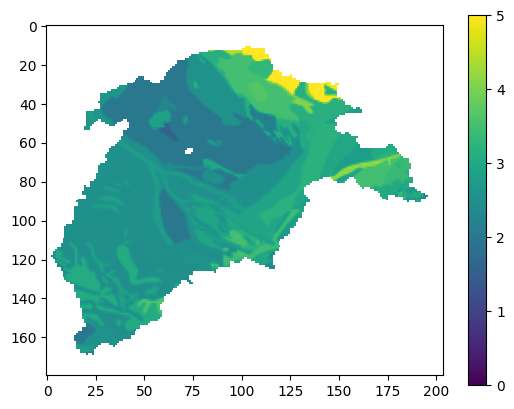

In [177]:
import numpy as np
sigma = (0.0742+0.0728)/2 # suface tension of water at 15 degree C
g = 9.81 # gravity
rho = 999.06 # density of water at 15 degree C
eta = 1.1375*0.001 # viscosity of water at 15 degree C
ha = 0.25 # average air entry suction head
hc = sigma * porosity / np.sqrt(2 * eta * rho * g * ksat_avg) * 0.5 + (1 - porosity) * ha
plt.imshow(hc,vmin = 0, vmax = 5)
plt.colorbar()
#setup min and max for colorbar
hcmin = np.nanmin(hc)
hcmax = np.nanmax(hc)
print(f'min hc is {hcmin} m')
print(f'max hc is {hcmax} m')

#print(sigma/np.sqrt(2 * eta * rho * g ))
from math import cos
from math import pi

sigma = 0.0728
g = 9.81
rho = 998.2
eta = 1.0016*0.001
#print(sigma/np.sqrt(2 * eta * rho * g ))
#print((sigma*0.408*cos(53.3*pi/180)  / np.sqrt(2 * eta * rho * g*0.15))+(1-0.408)*0.15)
#print((0.0164*0.408*cos(53.3*pi/180)  / np.sqrt(0.15))+(1-0.408)*0.15)


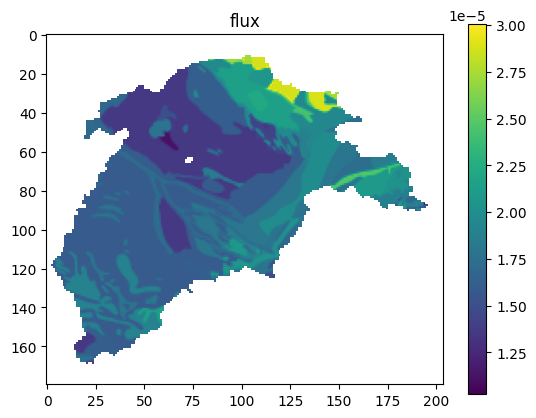

In [171]:
flux = hc * porosity


#flux = np.ma.masked_array(flux, mask=ksat200_mask)
plt.imshow(flux)
plt.title('flux')
plt.colorbar()

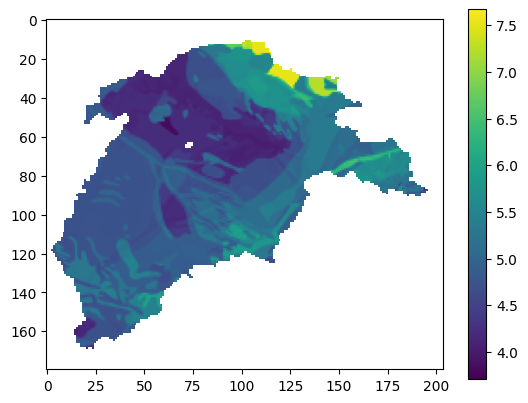

In [175]:
distinction = depth+hc
plt.imshow(distinction)
plt.colorbar()